In [90]:
from skimage.measure import block_reduce
import numpy as np

import logging

from utils import logging as lg
lg.set_logging(logging.ERROR)
from model import provider, heatmap_evaluation
import matplotlib.pyplot as plt



In [91]:
from utils import data_provider

In [92]:
dataset = {
    'mnist': data_provider.MNISTData(dir_path='../data/mnist'),
    'fashion-mnist': data_provider.FashionMNISTData(dir_path='../data/fashion-mnist'),
    'ufi-cropped': data_provider.UFICroppedData(dir_path='../data/ufi-cropped')
}

In [93]:
def model_path(network, dataset, seq):
    return '../final-models/%s_network-%s-seq-%d' % (network, dataset, seq)

In [94]:
def plot_apoc(networks, dataset_name, seq):
    data = dataset[dataset_name]
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    labels = []
    last_values = []
    for m in networks:
        path = model_path(m, dataset_name, seq)
        model_obj = provider.load(model_path(m, dataset_name, seq))
        apoc = heatmap_evaluation.aopc(model_obj, data.test2d.x)   
        name = provider.network_nickname(model_obj._.architecture_name)
        ax.plot(apoc, label=name)

        labels.append(name)
        last_values.append(apoc[-1])
    sorted_indices = np.argsort(-np.array(last_values))
    labels = np.array(labels)[sorted_indices]
    last_values = np.array(last_values)[sorted_indices]
    position = np.copy(last_values)
    ratio = 0.1
    for i in range(1, len(sorted_indices)):
        if position[i-1] - position[i] < ratio:
            position[i] = position[i] - ratio
                      
    for label, value, pos in zip(labels, last_values, position):
        ax.annotate(label,
                    xy=(len(apoc)-1,value),
                    xytext=(len(apoc),pos),
                    textcoords='data',
                    arrowprops=dict(arrowstyle="->",connectionstyle="arc3")
                   )
    plt.legend()
    plt.tight_layout()
    plt.title('AOPC of %s with seq-length=%d' % (dataset_name, seq))
    plt.show()

INFO:tensorflow:Restoring parameters from ../final-models/s2_network-mnist-seq-1/model.ckpt


2017-12-31 23:01:24,899 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s2_network-mnist-seq-1/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/s2_network-mnist-seq-1/model.ckpt


2017-12-31 23:01:27,014 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s2_network-mnist-seq-1/model.ckpt


[0, 0.31053881835937502, 0.50303046875000001, 0.65288896484375003, 0.77338925781250001, 0.87390722656249997, 0.95348798828125003, 1.0270511718749999, 1.08695634765625, 1.13978017578125, 1.1774526367187499, 1.2202249999999999, 1.2585932617187501, 1.2903084960937501, 1.3190199218750001, 1.35304130859375]
auto diff
[ 0.31053882  0.19249165  0.1498585   0.12050029  0.10051797  0.07958076
  0.07356318  0.05990518  0.05282383  0.03767246  0.04277236  0.03836826
  0.03171523  0.02871143  0.03402139]
INFO:tensorflow:Restoring parameters from ../final-models/s3_network-mnist-seq-1/model.ckpt


2017-12-31 23:01:32,363 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s3_network-mnist-seq-1/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/s3_network-mnist-seq-1/model.ckpt


2017-12-31 23:01:34,466 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s3_network-mnist-seq-1/model.ckpt


[0, 0.40293427734374998, 0.62037954101562498, 0.75301660156250005, 0.834238671875, 0.88971289062500003, 0.927065625, 0.95124541015624997, 0.96774130859374996, 0.97913320312499996, 0.98681269531250004, 0.99236044921875, 0.99627246093749999, 0.99918984374999997, 1.0011982421875001, 1.0024204101562499]
auto diff
[ 0.40293428  0.21744526  0.13263706  0.08122207  0.05547422  0.03735273
  0.02417979  0.0164959   0.01139189  0.00767949  0.00554775  0.00391201
  0.00291738  0.0020084   0.00122217]
INFO:tensorflow:Restoring parameters from ../final-models/deep_4l_network-mnist-seq-1/model.ckpt


2017-12-31 23:01:41,799 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/deep_4l_network-mnist-seq-1/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/deep_4l_network-mnist-seq-1/model.ckpt


2017-12-31 23:01:44,067 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/deep_4l_network-mnist-seq-1/model.ckpt


[0, 0.49321840820312501, 0.73070546874999998, 0.85262578124999999, 0.92122919921875002, 0.96002685546875, 0.98366884765624996, 0.99760927734375004, 1.0062357421874999, 1.0106808593750001, 1.0135896484375, 1.0149947265624999, 1.0163101562500001, 1.0167451171874999, 1.0161586914062499, 1.0151655273437501]
auto diff
[  4.93218408e-01   2.37487061e-01   1.21920313e-01   6.86034180e-02
   3.87976562e-02   2.36419922e-02   1.39404297e-02   8.62646484e-03
   4.44511719e-03   2.90878906e-03   1.40507812e-03   1.31542969e-03
   4.34960937e-04  -5.86425781e-04  -9.93164062e-04]
INFO:tensorflow:Restoring parameters from ../final-models/convdeep_4l_network-mnist-seq-1/model.ckpt


2017-12-31 23:01:50,544 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/convdeep_4l_network-mnist-seq-1/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/convdeep_4l_network-mnist-seq-1/model.ckpt


2017-12-31 23:02:07,511 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/convdeep_4l_network-mnist-seq-1/model.ckpt


[0, 0.1614094482421875, 0.28151430664062499, 0.38373168945312502, 0.47019838867187502, 0.54316582031250005, 0.60518637695312505, 0.65874814453124997, 0.70375078125000001, 0.74042714843750002, 0.771481298828125, 0.79899472656250003, 0.82319550781249995, 0.84515166015624998, 0.86299882812499995, 0.87809306640624996]
auto diff
[ 0.16140945  0.12010486  0.10221738  0.0864667   0.07296743  0.06202056
  0.05356177  0.04500264  0.03667637  0.03105415  0.02751343  0.02420078
  0.02195615  0.01784717  0.01509424]


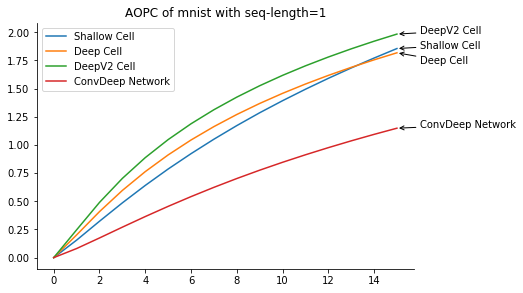

In [124]:
import imp
imp.reload(heatmap_evaluation)

plot_apoc(['s2', 's3', 'deep_4l', 'convdeep_4l'], 'mnist', 1)

INFO:tensorflow:Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-1/model.ckpt


2017-12-31 23:08:36,173 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-1/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-1/model.ckpt


2017-12-31 23:08:38,291 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-1/model.ckpt


[0, 0.3330133544921875, 0.55451162109374996, 0.72736352539062499, 0.86385947265624996, 0.98562763671874998, 1.1041856445312499, 1.1775764648437499, 1.27487041015625, 1.3703255859375001, 1.3823806640625, 1.410058984375, 1.41910546875, 1.4350448242187499, 1.4236629882812499, 1.44185556640625]
auto diff
[ 0.33301335  0.22149827  0.1728519   0.13649595  0.12176816  0.11855801
  0.07339082  0.09729395  0.09545518  0.01205508  0.02767832  0.00904648
  0.01593936 -0.01138184  0.01819258]
INFO:tensorflow:Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-1/model.ckpt


2017-12-31 23:08:43,647 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-1/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-1/model.ckpt


2017-12-31 23:08:45,461 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-1/model.ckpt


[0, 0.32618459472656253, 0.53666699218750002, 0.67922109374999995, 0.77355537109375005, 0.84125156249999999, 0.88911845703125003, 0.92584111328124996, 0.9548791015625, 0.97738378906250001, 0.99556669921874996, 1.01057412109375, 1.0208843750000001, 1.0286306640625, 1.0346942382812501, 1.0402208984375001]
auto diff
[ 0.32618459  0.2104824   0.1425541   0.09433428  0.06769619  0.04786689
  0.03672266  0.02903799  0.02250469  0.01818291  0.01500742  0.01031025
  0.00774629  0.00606357  0.00552666]
INFO:tensorflow:Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-1/model.ckpt


2017-12-31 23:08:51,373 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-1/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-1/model.ckpt


2017-12-31 23:08:53,308 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-1/model.ckpt


[0, 0.37334560546875001, 0.58703193359375005, 0.72478769531249998, 0.81019033203125002, 0.86933886718749998, 0.91102675781249998, 0.94478095703124998, 0.96850292968749996, 0.98596025390624997, 0.99978525390624995, 1.0150424804687499, 1.0247904296874999, 1.0359528320312501, 1.0443955078125, 1.0546357421874999]
auto diff
[ 0.37334561  0.21368633  0.13775576  0.08540264  0.05914854  0.04168789
  0.0337542   0.02372197  0.01745732  0.013825    0.01525723  0.00974795
  0.0111624   0.00844268  0.01024023]
INFO:tensorflow:Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-1/model.ckpt


2017-12-31 23:08:59,339 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-1/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-1/model.ckpt


2017-12-31 23:09:12,886 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-1/model.ckpt


[0, 0.13608411865234374, 0.24243112792968749, 0.32597333984374999, 0.39519990234375002, 0.45334360351562503, 0.50286870117187499, 0.54683017578125004, 0.58600185546875005, 0.62109228515625003, 0.65286699218749999, 0.68138789062500005, 0.70824033203125003, 0.73412978515625005, 0.75625502929687505, 0.77772338867187496]
auto diff
[ 0.13608412  0.10634701  0.08354221  0.06922656  0.0581437   0.0495251
  0.04396147  0.03917168  0.03509043  0.03177471  0.0285209   0.02685244
  0.02588945  0.02212524  0.02146836]


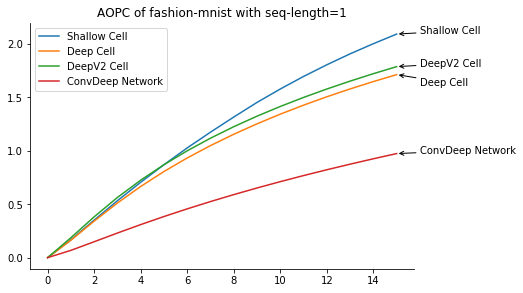

In [125]:
plot_apoc(['s2', 's3', 'deep_4l', 'convdeep_4l'], 'fashion-mnist', 1)

INFO:tensorflow:Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-4/model.ckpt


2017-12-31 12:05:18,538 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-4/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-4/model.ckpt


2017-12-31 12:05:21,670 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-4/model.ckpt


[0, 0.109031005859375, 0.16434614257812499, 0.21784057617187499, 0.22616955566406249, 0.20718732910156251, 0.230751708984375, 0.22134345703125, 0.27065239257812501, 0.32519172363281251, 0.39201188964843747, 0.41462622070312499, 0.424714453125, 0.42571689453125, 0.40656186523437499, 0.47200395507812498]
auto diff
[ 0.10903101  0.05531514  0.05349443  0.00832898 -0.01898223  0.02356438
 -0.00940825  0.04930894  0.05453933  0.06682017  0.02261433  0.01008823
  0.00100244 -0.01915503  0.06544209]
INFO:tensorflow:Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-4/model.ckpt


2017-12-31 12:05:31,324 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-4/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-4/model.ckpt


2017-12-31 12:05:34,588 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-4/model.ckpt


[0, 0.22046015625000001, 0.35352255859374998, 0.44709023437500001, 0.50522309570312496, 0.558599951171875, 0.60882182617187497, 0.64630908203125004, 0.67860039062499999, 0.71208647460937502, 0.74006103515624999, 0.77053603515625002, 0.79027460937500005, 0.81127939453124998, 0.81759189453125003, 0.86374970703124998]
auto diff
[ 0.22046016  0.1330624   0.09356768  0.05813286  0.05337686  0.05022187
  0.03748726  0.03229131  0.03348608  0.02797456  0.030475    0.01973857
  0.02100479  0.0063125   0.04615781]
INFO:tensorflow:Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-4/model.ckpt


2017-12-31 12:05:46,568 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-4/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-4/model.ckpt


2017-12-31 12:05:50,190 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-4/model.ckpt


[0, 0.28257766113281252, 0.43364208984375002, 0.52344897460937501, 0.58254848632812495, 0.62774799804687498, 0.65751005859375, 0.68617382812500005, 0.73357050781249999, 0.76916152343749999, 0.79456772460937497, 0.81203813476562503, 0.82723476562499998, 0.82968496093749999, 0.83011210937500002, 0.86868525390624995]
auto diff
[ 0.28257766  0.15106443  0.08980688  0.05909951  0.04519951  0.02976206
  0.02866377  0.04739668  0.03559102  0.0254062   0.01747041  0.01519663
  0.0024502   0.00042715  0.03857314]
INFO:tensorflow:Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-4/model.ckpt


2017-12-31 12:06:02,201 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-4/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-4/model.ckpt


2017-12-31 12:06:12,980 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-4/model.ckpt


[0, 0.13250781249999999, 0.21943134765625, 0.30913750000000001, 0.39371132812499998, 0.46637470703125, 0.52876494140624997, 0.59033369140625003, 0.64156923828125001, 0.68992978515625003, 0.73292939453124994, 0.77287856445312497, 0.80685312499999995, 0.83647128906250001, 0.85259218749999999, 0.87147089843750003]
auto diff
[ 0.13250781  0.08692354  0.08970615  0.08457383  0.07266338  0.06239023
  0.06156875  0.05123555  0.04836055  0.04299961  0.03994917  0.03397456
  0.02961816  0.0161209   0.01887871]


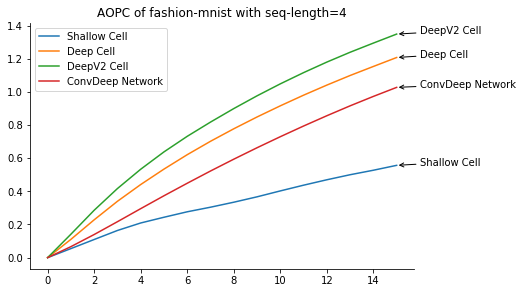

In [96]:
plot_apoc(['s2', 's3', 'deep_4l', 'convdeep_4l'], 'fashion-mnist', 4)

INFO:tensorflow:Restoring parameters from ../final-models/s2_network-mnist-seq-7/model.ckpt


2017-12-31 12:06:58,887 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s2_network-mnist-seq-7/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/s2_network-mnist-seq-7/model.ckpt


2017-12-31 12:07:03,091 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s2_network-mnist-seq-7/model.ckpt


[0, 0.038085116577148435, 0.061255889892578123, 0.073966046142578123, 0.07443447265625, 0.077030670166015627, 0.087056018066406254, 0.09287041015625, 0.15289306640625, 0.21005705566406249, 0.23663811035156249, 0.26790327148437498, 0.28203322753906251, 0.26881845703125001, 0.23856882324218751, 0.32506206054687498]
auto diff
[ 0.03808512  0.02317077  0.01271016  0.00046843  0.0025962   0.01002535
  0.00581439  0.06002266  0.05716399  0.02658105  0.03126516  0.01412996
 -0.01321477 -0.03024963  0.08649324]
INFO:tensorflow:Restoring parameters from ../final-models/s3_network-mnist-seq-7/model.ckpt


2017-12-31 12:07:16,448 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s3_network-mnist-seq-7/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/s3_network-mnist-seq-7/model.ckpt


2017-12-31 12:07:21,041 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s3_network-mnist-seq-7/model.ckpt


[0, 0.24575849609375, 0.39625644531249998, 0.50601840820312505, 0.58505537109375005, 0.643050927734375, 0.70943916015624997, 0.76327675781250004, 0.80545644531250005, 0.83678007812499999, 0.86304208984374997, 0.89441533203125001, 0.92422861328125006, 0.95169775390625, 0.97639814453124996, 0.99851113281250004]
auto diff
[ 0.2457585   0.15049795  0.10976196  0.07903696  0.05799556  0.06638823
  0.0538376   0.04217969  0.03132363  0.02626201  0.03137324  0.02981328
  0.02746914  0.02470039  0.02211299]
INFO:tensorflow:Restoring parameters from ../final-models/deep_4l_network-mnist-seq-7/model.ckpt


2017-12-31 12:07:39,116 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/deep_4l_network-mnist-seq-7/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/deep_4l_network-mnist-seq-7/model.ckpt


2017-12-31 12:07:44,569 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/deep_4l_network-mnist-seq-7/model.ckpt


[0, 0.30305776367187498, 0.47685805664062503, 0.58059702148437498, 0.64270419921874999, 0.68874453125000001, 0.73287500000000005, 0.78342832031249998, 0.83725996093749999, 0.86973828124999997, 0.89260507812500001, 0.91381064453125005, 0.93146093750000003, 0.9506818359375, 0.96733671875000005, 0.97912500000000002]
auto diff
[ 0.30305776  0.17380029  0.10373896  0.06210718  0.04604033  0.04413047
  0.05055332  0.05383164  0.03247832  0.0228668   0.02120557  0.01765029
  0.0192209   0.01665488  0.01178828]
INFO:tensorflow:Restoring parameters from ../final-models/convdeep_4l_network-mnist-seq-7/model.ckpt


2017-12-31 12:08:01,978 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/convdeep_4l_network-mnist-seq-7/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/convdeep_4l_network-mnist-seq-7/model.ckpt


2017-12-31 12:08:13,123 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/convdeep_4l_network-mnist-seq-7/model.ckpt


[0, 0.16523824462890624, 0.29513032226562502, 0.40602231445312498, 0.50052827148437495, 0.57661494140625003, 0.64042792968749995, 0.69891494140624999, 0.74980473632812505, 0.79653422851562505, 0.83514453124999999, 0.87019160156249997, 0.89945957031250001, 0.92634589843750004, 0.95120126953124995, 0.97186953124999997]
auto diff
[ 0.16523824  0.12989208  0.11089199  0.09450596  0.07608667  0.06381299
  0.05848701  0.05088979  0.04672949  0.0386103   0.03504707  0.02926797
  0.02688633  0.02485537  0.02066826]


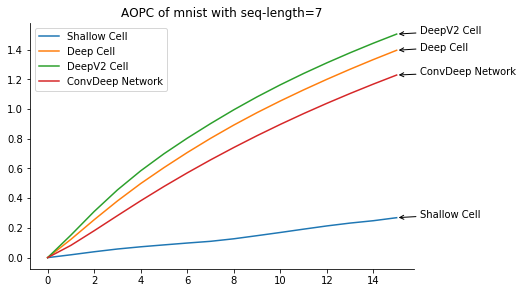

In [97]:
plot_apoc(['s2', 's3', 'deep_4l', 'convdeep_4l'], 'mnist', 7)

INFO:tensorflow:Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-7/model.ckpt


2017-12-31 12:08:57,455 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-7/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-7/model.ckpt


2017-12-31 12:09:01,515 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s2_network-fashion-mnist-seq-7/model.ckpt


[0, 0.062671014404296871, 0.14368004150390626, 0.20195908203124999, 0.2535736572265625, 0.25508671875, 0.26508662109374997, 0.23701904296875001, 0.32215002441406249, 0.33357536621093747, 0.32019921875000001, 0.38826242675781247, 0.54327739257812502, 0.49722768554687502, 0.58258979492187501, 0.57382851562500004]
auto diff
[ 0.06267101  0.08100903  0.05827904  0.05161458  0.00151306  0.0099999
 -0.02806758  0.08513098  0.01142534 -0.01337615  0.06806321  0.15501497
 -0.04604971  0.08536211 -0.00876128]
INFO:tensorflow:Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-7/model.ckpt


2017-12-31 12:09:15,126 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-7/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-7/model.ckpt


2017-12-31 12:09:20,072 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/s3_network-fashion-mnist-seq-7/model.ckpt


[0, 0.2173828857421875, 0.361487548828125, 0.462040771484375, 0.5651453125, 0.62300107421874995, 0.66717089843749999, 0.71950205078124996, 0.78593144531250003, 0.83934697265625002, 0.87679326171875005, 0.90868876953125, 0.92850126953125001, 0.94064082031249996, 0.94696279296874997, 0.96699023437499998]
auto diff
[ 0.21738289  0.14410466  0.10055322  0.10310454  0.05785576  0.04416982
  0.05233115  0.06642939  0.05341553  0.03744629  0.03189551  0.0198125
  0.01213955  0.00632197  0.02002744]
INFO:tensorflow:Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-7/model.ckpt


2017-12-31 12:09:40,461 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-7/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-7/model.ckpt


2017-12-31 12:09:45,496 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/deep_4l_network-fashion-mnist-seq-7/model.ckpt


[0, 0.25084624023437502, 0.39588449707031248, 0.47878823242187502, 0.54170444335937495, 0.58779814453125001, 0.62454521484375003, 0.67466611328125003, 0.76830527343749999, 0.83160087890625001, 0.85489433593749997, 0.88344824218749995, 0.91598349609374996, 0.92111347656249998, 0.91924150390625003, 0.94197216796875005]
auto diff
[ 0.25084624  0.14503826  0.08290374  0.06291621  0.0460937   0.03674707
  0.0501209   0.09363916  0.06329561  0.02329346  0.02855391  0.03253525
  0.00512998 -0.00187197  0.02273066]
INFO:tensorflow:Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-7/model.ckpt


2017-12-31 12:10:03,319 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-7/model.ckpt


INFO:tensorflow:Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-7/model.ckpt


2017-12-31 12:10:14,073 | INFO : tf_logging.py(info 82) - Restoring parameters from ../final-models/convdeep_4l_network-fashion-mnist-seq-7/model.ckpt


[0, 0.14319197998046876, 0.258632275390625, 0.3607213134765625, 0.45576684570312498, 0.54190258789062495, 0.61448266601562496, 0.68065478515625, 0.73364091796874997, 0.78027192382812505, 0.82249042968749997, 0.85926894531249998, 0.89041044921875001, 0.91153310546874999, 0.92252128906249997, 0.93494238281249997]
auto diff
[ 0.14319198  0.1154403   0.10208904  0.09504553  0.08613574  0.07258008
  0.06617212  0.05298613  0.04663101  0.04221851  0.03677852  0.0311415
  0.02112266  0.01098818  0.01242109]


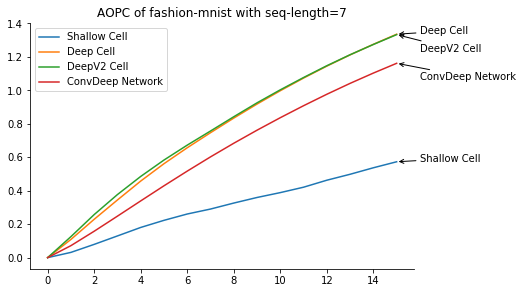

In [98]:
plot_apoc(['s2', 's3', 'deep_4l', 'convdeep_4l'], 'fashion-mnist', 7)